In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import scipy
import os
import math
import shutil 
import numpy as np
from tensorflow.python.client import device_lib
from tensorflow.keras.applications import InceptionV3, ResNet152V2, VGG19
from keras.models import Sequential 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Input, Flatten, Dense, MaxPooling2D, BatchNormalization,AveragePooling2D,LSTM,TimeDistributed, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint , EarlyStopping
from keras.models import load_model 
from tensorflow.keras.preprocessing import image
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Prepare Dataset

In [4]:
batchsize = 8
ROOT_DIR = "C:/Users/igosa/Documents/Kuliah/Semester 5/Metodelogi penelitian/Model/DATASET"

In [4]:
num_img = {}

for dir in os.listdir(ROOT_DIR): 
  num_img[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

num_img.items()

dict_items([('no', 5), ('yes', 4)])

In [5]:
def dataFolder(p,s): 
  if not os.path.exists("./"+ p): 
    os.mkdir("./" + p)
    for dir in os.listdir(ROOT_DIR): 
      os.makedirs("./" + p + "/" + dir)

      for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)), 
                                  size = (math.floor(s * num_img[dir])-1), 
                                  replace=False) : 
        O = os.path.join(ROOT_DIR, dir, img)
        D  = os.path.join("./" + p, dir)
        shutil.copy(O,D)
        os.remove(O)
  else: 
    print(f"{p} folder exist")   

In [36]:
dataFolder("train", 0.7)
dataFolder("val", 0.15)
dataFolder("test", 0.15)

val folder exist
test folder exist


In [5]:
def preprocess(p): 
  image_data = ImageDataGenerator(
      zoom_range = 0.2, 
      shear_range = 0.2, 
      rescale = 1/255, 
      horizontal_flip=True)
  image = image_data.flow_from_directory(
      directory = p, target_size = (224,224), 
      batch_size = batchsize , 
      class_mode='categorical', 
      shuffle=True)

  return image

In [6]:
def preprocess2(p): 
  image_data = ImageDataGenerator( rescale = 1/255)
  image = image_data.flow_from_directory(
      directory = p, target_size = (224,224), 
      batch_size = batchsize , 
      class_mode='categorical', 
      shuffle=True)
  return image


In [7]:
p = './train'
train_data = preprocess(p)

Found 2216 images belonging to 2 classes.


In [8]:
p = './val'
val_data = preprocess2(p)

Found 472 images belonging to 2 classes.


In [9]:
p = './test'
test_data = preprocess2(p)

Found 472 images belonging to 2 classes.


# Model Building

In [11]:
bmodel = InceptionV3(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))
hmodel = Sequential()
hmodel = bmodel.output
hmodel = AveragePooling2D(pool_size = (3,3))(hmodel)
hmodel = TimeDistributed(Flatten())(hmodel)

# The only layers we need to train
# This is the layers' illustration https://www.google.com/url?sa=i&url=https%3A%2F%2Ftowardsdatascience.com%2Fthe-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480&psig=AOvVaw0CYHQ2oruhWMmKK2Lxm5cN&ust=1668996857968000&source=images&cd=vfe&ved=0CBAQjRxqFwoTCLDJs9TYu_sCFQAAAAAdAAAAABAU
hmodel = LSTM(512, dropout=0.5,  recurrent_dropout=0.5)(hmodel)
hmodel = BatchNormalization()(hmodel)
hmodel = Dropout(0.25)(hmodel)
hmodel = Dense(128, activation = "relu")(hmodel)
hmodel = Dropout(0.25)(hmodel)
hmodel = Dense(128, activation = "relu")(hmodel)
hmodel = Dropout(0.25)(hmodel)

hmodel = Dense(2, activation='sigmoid')(hmodel)

modelInc = Model(inputs=bmodel.input, outputs=hmodel)

for layer in bmodel.layers:
    layer.trainable = False

modelInc.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

 conv2d_11 (Conv2D)             (None, 25, 25, 32)   6144        ['average_pooling2d[0][0]']      
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_22 (Conv2D)             (None, 25, 25, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23

                                                                                                  
 activation_29 (Activation)     (None, 12, 12, 96)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
          

                                                                  'activation_33[0][0]',          
                                                                  'activation_38[0][0]',          
                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
          

                                                                                                  
 batch_normalization_54 (BatchN  (None, 12, 12, 160)  480        ['conv2d_54[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_65 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_64[0][0]']          
                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66

                                                                                                  
 activation_73 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_73[0][0]'] 
                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_nor

 conv2d_84 (Conv2D)             (None, 5, 5, 192)    245760      ['average_pooling2d_7[0][0]']    
                                                                                                  
 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
          

                                                                                                  
 activation_88 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_88[0][0]'] 
                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 5, 5, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

In [61]:
bmodelVGG = VGG19(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))
hmodel1 = Sequential()
hmodel1 = bmodelVGG.output 
hmodel1 = AveragePooling2D(pool_size =(3,3))(hmodel1)
hmodel1 = TimeDistributed(Flatten())(hmodel1)

#Train this layer 
hmodel1 = LSTM(512, dropout=0.5,  recurrent_dropout=0.5)(hmodel1)
hmodel1 = BatchNormalization()(hmodel1)
hmodel1 = Dropout(0.25)(hmodel1)
hmodel1 = Dense(128, activation = "relu")(hmodel1)
hmodel1 = Dropout(0.25)(hmodel1)
hmodel1 = Dense(128, activation = "relu")(hmodel1)
hmodel1 = Dropout(0.25)(hmodel1)
hmodel1 = Dense(2, activation='sigmoid')(hmodel1)
modelVGG = Model(inputs=bmodelVGG.input, outputs=hmodel1)

for layer in bmodelVGG.layers:
    layer.trainable = False
modelVGG.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

# Train Model

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [62]:
opt = Adam(learning_rate=1e-5, decay=1e-5 /50)
modelInc.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
modelVGG.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
esInc = EarlyStopping(monitor='val_loss', 
                      min_delta = 0.01, 
                      patience= 8, verbose = 1, 
                      mode='auto')

mcInc = ModelCheckpoint(monitor='val_loss', 
                        filepath = "bestModel/IncModel.h5", 
                        verbose = 1, 
                        save_best_only=True,  
                        mode='auto')

learning_rateInc = ReduceLROnPlateau(monitor='val_loss', 
                                     factor=0.2,  
                                     patience=3, 
                                     verbose=1 ,
                                     min_lr=0.00001
                                     ,cooldown=1 )

cdInc = [esInc,mcInc , learning_rateInc]

In [63]:
esVGG = EarlyStopping(monitor='val_loss', 
                      min_delta = 0.01, 
                      patience= 8, 
                      verbose = 1, 
                      mode='auto')

mcVGG = ModelCheckpoint(monitor='val_loss', 
                        filepath = "bestModel/VGGModel.h5", 
                        verbose = 1, save_best_only=True,  
                        mode='auto')

learning_rateVGG = ReduceLROnPlateau(monitor='val_loss', 
                                     factor=0.2,  
                                     patience=3, 
                                     verbose=1 ,
                                     min_lr=0.00001,
                                     cooldown=1 )

cdVGG = [esVGG,mcVGG, learning_rateVGG]

In [16]:
hsInc = modelInc.fit_generator(generator = train_data, 
                         steps_per_epoch=train_data.samples//batchsize,
                         epochs= 50, 
                         verbose=1, 
                         validation_data=val_data , 
                         validation_steps=val_data.samples//batchsize , 
                         callbacks = cdInc, 
                         )

Epoch 1/50


C:\Users\igosa\AppData\Local\Temp\ipykernel_19328\2929962471.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hsInc = modelInc.fit_generator(generator = train_data,


277/277 [==============================] - ETA: 0s - loss: 0.7944 - accuracy: 0.5957
Epoch 1: val_loss improved from inf to 0.51068, saving model to bestModel\IncModel.h5
277/277 [==============================] - 33s 87ms/step - loss: 0.7944 - accuracy: 0.5957 - val_loss: 0.5107 - val_accuracy: 0.8962 - lr: 1.0000e-05
Epoch 2/50
277/277 [==============================] - ETA: 0s - loss: 0.6104 - accuracy: 0.7004
Epoch 2: val_loss improved from 0.51068 to 0.31377, saving model to bestModel\IncModel.h5
277/277 [==============================] - 22s 81ms/step - loss: 0.6104 - accuracy: 0.7004 - val_loss: 0.3138 - val_accuracy: 0.9258 - lr: 1.0000e-05
Epoch 3/50
277/277 [==============================] - ETA: 0s - loss: 0.4978 - accuracy: 0.7717
Epoch 3: val_loss improved from 0.31377 to 0.25976, saving model to bestModel\IncModel.h5
277/277 [==============================] - 23s 81ms/step - loss: 0.4978 - accuracy: 0.7717 - val_loss: 0.2598 - val_accuracy: 0.9322 - lr: 1.0000e-05
Epoch 4

Epoch 26/50
277/277 [==============================] - ETA: 0s - loss: 0.2781 - accuracy: 0.8935
Epoch 26: val_loss did not improve from 0.15149
277/277 [==============================] - 22s 80ms/step - loss: 0.2781 - accuracy: 0.8935 - val_loss: 0.1525 - val_accuracy: 0.9513 - lr: 1.0000e-05
Epoch 27/50
277/277 [==============================] - ETA: 0s - loss: 0.2760 - accuracy: 0.8971
Epoch 27: val_loss improved from 0.15149 to 0.15030, saving model to bestModel\IncModel.h5
277/277 [==============================] - 22s 81ms/step - loss: 0.2760 - accuracy: 0.8971 - val_loss: 0.1503 - val_accuracy: 0.9513 - lr: 1.0000e-05
Epoch 28/50
277/277 [==============================] - ETA: 0s - loss: 0.2627 - accuracy: 0.8989
Epoch 28: val_loss improved from 0.15030 to 0.14921, saving model to bestModel\IncModel.h5
277/277 [==============================] - 23s 81ms/step - loss: 0.2627 - accuracy: 0.8989 - val_loss: 0.1492 - val_accuracy: 0.9513 - lr: 1.0000e-05
Epoch 29/50
277/277 [========

In [64]:
hsVGG = modelVGG.fit_generator(generator = train_data, 
                         steps_per_epoch=train_data.samples//batchsize,
                         epochs= 50, 
                         verbose=1, 
                         validation_data=val_data , 
                         validation_steps=val_data.samples//batchsize , 
                         callbacks = cdVGG, 
                         )

Epoch 1/50


C:\Users\igosa\AppData\Local\Temp\ipykernel_19328\1293718730.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hsVGG = modelVGG.fit_generator(generator = train_data,


277/277 [==============================] - ETA: 0s - loss: 0.8718 - accuracy: 0.5451
Epoch 1: val_loss improved from inf to 0.60616, saving model to bestModel\VGGModel.h5
277/277 [==============================] - 29s 87ms/step - loss: 0.8718 - accuracy: 0.5451 - val_loss: 0.6062 - val_accuracy: 0.8496 - lr: 1.0000e-05
Epoch 2/50
277/277 [==============================] - ETA: 0s - loss: 0.7333 - accuracy: 0.6178
Epoch 2: val_loss improved from 0.60616 to 0.45131, saving model to bestModel\VGGModel.h5
277/277 [==============================] - 23s 84ms/step - loss: 0.7333 - accuracy: 0.6178 - val_loss: 0.4513 - val_accuracy: 0.8919 - lr: 1.0000e-05
Epoch 3/50
277/277 [==============================] - ETA: 0s - loss: 0.6683 - accuracy: 0.6408
Epoch 3: val_loss improved from 0.45131 to 0.36803, saving model to bestModel\VGGModel.h5
277/277 [==============================] - 24s 86ms/step - loss: 0.6683 - accuracy: 0.6408 - val_loss: 0.3680 - val_accuracy: 0.9047 - lr: 1.0000e-05
Epoch 4

277/277 [==============================] - 23s 83ms/step - loss: 0.3499 - accuracy: 0.8655 - val_loss: 0.1921 - val_accuracy: 0.9343 - lr: 1.0000e-05
Epoch 26/50
277/277 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.8664
Epoch 26: val_loss improved from 0.19209 to 0.18964, saving model to bestModel\VGGModel.h5
277/277 [==============================] - 23s 84ms/step - loss: 0.3342 - accuracy: 0.8664 - val_loss: 0.1896 - val_accuracy: 0.9364 - lr: 1.0000e-05
Epoch 27/50
277/277 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.8497
Epoch 27: val_loss improved from 0.18964 to 0.18788, saving model to bestModel\VGGModel.h5
277/277 [==============================] - 23s 84ms/step - loss: 0.3408 - accuracy: 0.8497 - val_loss: 0.1879 - val_accuracy: 0.9386 - lr: 1.0000e-05
Epoch 28/50
277/277 [==============================] - ETA: 0s - loss: 0.3502 - accuracy: 0.8633
Epoch 28: val_loss improved from 0.18788 to 0.18710, saving model to bestMode

# Evaluate InceptionV3 Model

In [17]:
hInc = hsInc.history

hInc.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

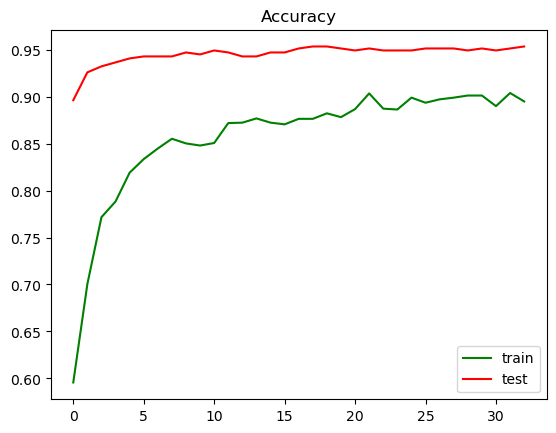

In [76]:
plt.title('Accuracy')
plt.plot(hInc['accuracy'] ,c = "green", label='train' )
plt.plot(hInc['val_accuracy'] ,c = "red", label='test')
plt.legend()
plt.show()

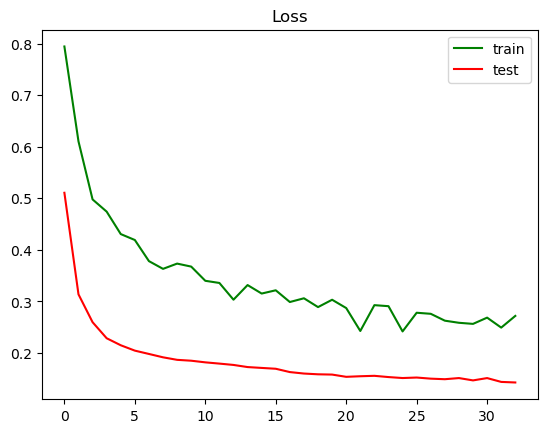

In [77]:
plt.title('Loss')
plt.plot(hInc['loss'] ,c = "green", label='train' )
plt.plot(hInc['val_loss'] ,c = "red", label='test')
plt.legend()
plt.show()

In [2]:
best_model = load_model("bestModel/IncModel.h5")

In [27]:
acc = modelInc.evaluate(val_data)[1]

print(f"the accuracy of model is {acc * 100}")

59/59 [==============================] - 2s 23ms/step - loss: 0.1429 - accuracy: 0.9534
the accuracy of model is 95.3389823436737


In [23]:
acc_test, loss_test = best_model.evaluate(test_data)
print(acc_test)
print(loss_test)

59/59 [==============================] - 2s 23ms/step - loss: 0.1446 - accuracy: 0.9449
0.1445792019367218
0.944915235042572


In [10]:
test_generator = ImageDataGenerator( rescale = 1/255)
test_data_generator = test_generator.flow_from_directory(
    './test',
     target_size=(224, 224),
    batch_size=batchsize,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = best_model.predict(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

Found 472 images belonging to 2 classes.
59/59 [==============================] - 10s 24ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1

In [11]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())
print(class_labels)

['no', 'yes']


In [12]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

              precision    recall  f1-score   support

          no       0.94      0.95      0.95       252
         yes       0.94      0.94      0.94       220

    accuracy                           0.94       472
   macro avg       0.94      0.94      0.94       472
weighted avg       0.94      0.94      0.94       472



In [13]:
probabilities = best_model.predict(test_data_generator)
y_pred = np.argmax(probabilities, axis = 1)

print(confusion_matrix(test_data.classes, y_pred))

59/59 [==============================] - 2s 26ms/step
[[240  12]
 [ 14 206]]


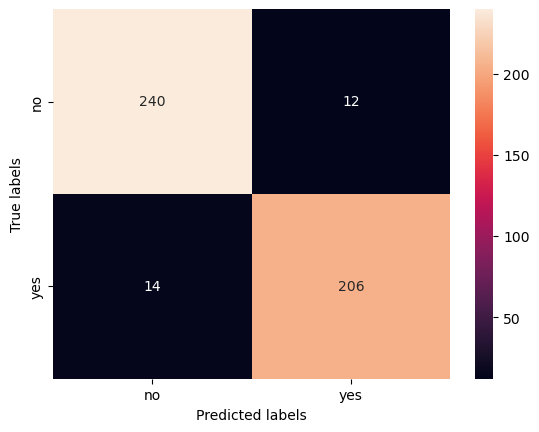

<Figure size 1200x800 with 0 Axes>

In [15]:
ax = plt.subplot() 
cf_matrix = confusion_matrix(test_data.classes, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix, annot=True, fmt='g', ax= ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(['no', 'yes']); ax.yaxis.set_ticklabels(['no', 'yes']);

# Evaluate VGG Model 

In [65]:
hVGG = hsVGG.history

hVGG.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

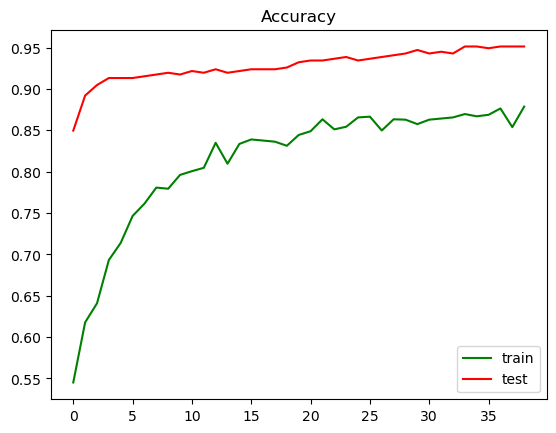

In [66]:
plt.title('Accuracy')
plt.plot(hVGG['accuracy'] ,c = "green", label='train' )
plt.plot(hVGG['val_accuracy'] ,c = "red", label='test')
plt.legend()
plt.show()

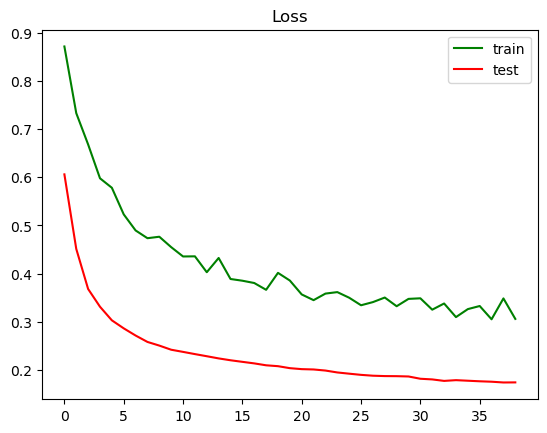

In [67]:
plt.title('Loss')
plt.plot(hVGG['loss'] ,c = "green", label='train' )
plt.plot(hVGG['val_loss'] ,c = "red", label='test')
plt.legend()
plt.show()

In [16]:
best_model_VGG = load_model("bestModel/VGGModel.h5")

In [18]:
acc = best_model_VGG.evaluate(val_data)[1]

print(f"the accuracy of model is {acc * 100}")

59/59 [==============================] - 5s 47ms/step - loss: 0.1738 - accuracy: 0.9513
the accuracy of model is 95.12711763381958


In [19]:
acc_test, loss_test = best_model_VGG.evaluate(test_data)
print(acc_test)
print(loss_test)

59/59 [==============================] - 3s 47ms/step - loss: 0.1479 - accuracy: 0.9470
0.1479254812002182
0.9470338821411133


In [20]:
test_generator = ImageDataGenerator( rescale = 1/255)
test_data_generator = test_generator.flow_from_directory(
    './test',
     target_size=(224, 224),
    batch_size=batchsize,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = best_model_VGG.predict(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

Found 472 images belonging to 2 classes.
59/59 [==============================] - 3s 49ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 

In [21]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())
print(class_labels)

['no', 'yes']


In [22]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

              precision    recall  f1-score   support

          no       0.95      0.96      0.95       252
         yes       0.95      0.94      0.94       220

    accuracy                           0.95       472
   macro avg       0.95      0.95      0.95       472
weighted avg       0.95      0.95      0.95       472



In [23]:
probabilities = best_model_VGG.predict(test_data_generator)
y_pred = np.argmax(probabilities, axis = 1)

print(confusion_matrix(test_data.classes, y_pred))

59/59 [==============================] - 3s 49ms/step
[[241  11]
 [ 14 206]]


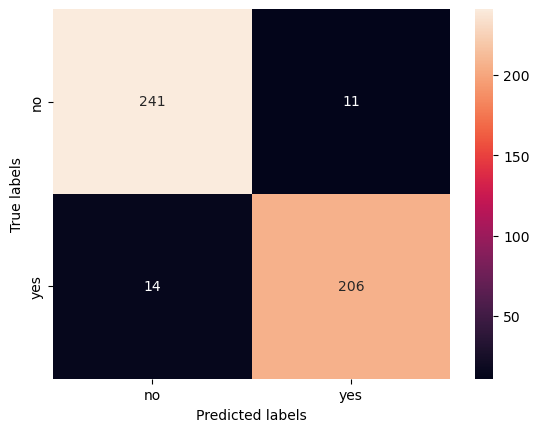

<Figure size 1200x800 with 0 Axes>

In [24]:
ax = plt.subplot() 
cf_matrix = confusion_matrix(test_data.classes, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix, annot=True, fmt='g', ax= ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(['no', 'yes']); ax.yaxis.set_ticklabels(['no', 'yes']);